# Simple Improved Reference Subtraction (SIRS)<br>James Webb Space Telescope NIRCam Example

Bernard.J.Rauscher@nasa.gov<br>
29 July 2021

This notebook shows how to compute the SIRS frequency dependent weights for a JWST NIRCam detector. This is the SIRS "front-end".

In [1]:
# Standard imports
using Revise        # Handy for interactive work
using Glob          # Filename globbing
using FITSIO        # Julia's standard FITS package
using Jacobi        # Legendre polynomials defined here
using LinearAlgebra # Moore-Penrose inverse is here
using OMEinsum      # Tensor operations
using StatsBase     # Robuts statistics
using Plots         # Plotting
using JLD           # Saving results

# Simple Improved Reference Subtraction (SIRS)
using SIRS

┌ Info: Precompiling SIRS [40ae95f3-0455-409b-a0fb-071cca222575]
└ @ Base loading.jl:1342


In [2]:
# The data are here
ddir = ENV["HOME"]*"/data1/JWST/NIRCam/"

# Put the results here
rdir = ENV["HOME"]*"/tmp/";

In [3]:
# Get a list of the input files
files = glob("*.fits", ddir)

# Exclude the last so that it can be used to check the result
files = files[1:end-1];

In [4]:
# Instantiate a SIRSCore. From looking at the FITS headers, I know that
# the files have 108 frames sampled up-the-ramp. For JWST:
# - 2048x2048 pixels
# - 4 outputs
# - 12 pixels overhead at end of each line
# - 10 µs pixel dwell time
sc = SIRSCore("h2rg", 4, 12, 10.e-6, 108);

In [5]:
# Coadd in preparation for solving for α and β.
@time for file in files
    
    # Show some status
    println("Processing file: ", file)
   
    # JWST NIRCam data
    f = FITS(file, "r")
    D = Float64.(read(f[1]))
    close(f)
        
    # Coadd
    coadd!(sc, D)

end

Processing file: /local/data/home/brausche/data1/JWST/NIRCam/NRCNRCALONG-DARK-53510917431_1_485_SE_2015-12-17T10h15m23.fits
Processing file: /local/data/home/brausche/data1/JWST/NIRCam/NRCNRCALONG-DARK-53511010201_1_485_SE_2015-12-17T11h05m42.fits
Processing file: /local/data/home/brausche/data1/JWST/NIRCam/NRCNRCALONG-DARK-53520943021_1_485_SE_2015-12-18T10h40m58.fits
Processing file: /local/data/home/brausche/data1/JWST/NIRCam/NRCNRCALONG-DARK-53521422131_1_485_SE_2015-12-18T15h05m59.fits
Processing file: /local/data/home/brausche/data1/JWST/NIRCam/NRCNRCALONG-DARK-53531519121_1_485_SE_2015-12-19T15h59m34.fits
Processing file: /local/data/home/brausche/data1/JWST/NIRCam/NRCNRCALONG-DARK-53541744151_1_485_SE_2015-12-20T18h37m58.fits
Processing file: /local/data/home/brausche/data1/JWST/NIRCam/NRCNRCALONG-DARK-53542343451_1_485_SE_2015-12-21T00h28m33.fits
Processing file: /local/data/home/brausche/data1/JWST/NIRCam/NRCNRCALONG-DARK-53550409111_1_485_SE_2015-12-21T07h06m30.fits
Processi

In [6]:
# Solve for frequency dependent weights
solve!(sc);

In [7]:
# Save results
SIRS.save(sc, rdir*"20151217_nircam_sirs.jld")
export_to_sirspy(sc, rdir*"20151217_nircam_sirs.h5");

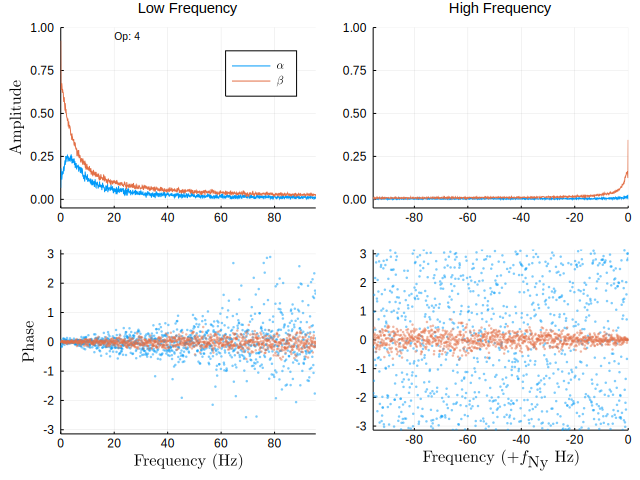

In [12]:
# Make a plot to show that they are reasonable
op1 = wplot(sc, 4, nice=false) # The second parameter is the output number selected
                               # from {1,2,3,4}.